# Sentiment Analysis

Ref : https://pythainlp.org/tutorials/notebooks/sentiment_analysis.html

In [ ]:
# !pip install sklearn_crfsuite
# !pip install emoji
# !pip install https://github.com/PyThaiNLP/pythainlp/archive/dev.zip
# !pip install xgboost
# !pip install transformers

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import numpy as np
import pandas as pd

from pythainlp import word_tokenize
from tqdm import tqdm_notebook
from pythainlp.ulmfit import process_thai
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#viz
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'TH Sarabun New'


C:\Users\FOth-PC\AppData\Roaming\Python\Python310\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Input data

In [3]:
# 3. โหลดข้อมูล
df = pd.read_excel('rawdata_sentiment.xlsx')
print("data sentiment shape", df.shape)
df.to_csv('rawdata_sentiment.csv',index=False)
df.head()

data sentiment shape (3000, 2)


,Text,Sentiment
0,นี้ๆชวนบ่อยสะ,neu
1,"(พยาบาลพัฒนาระบบคุณภาพ), โรงพยาบาลกรุงเทพภูเก็...",neu
2,เคยเจอแบบนี้ตอนนั่งแท็กซี่กลับจากคอนเสิร์ตคนเด...,neu
3,นิสสันมาแหะ,neu
4,อยากกินอ่ะหมู 😣😣😣,pos


In [4]:
# 4. ตัดคำไทย
def thai_tokenizer(text):
    return word_tokenize(str(text), engine='newmm')

df["processed"] = df["Text"].map(lambda x: "|".join(thai_tokenizer(x)))
df["wc"] = df.processed.map(lambda x: len(x.split("|")))
df["uwc"] = df.processed.map(lambda x: len(set(x.split("|"))))

In [5]:
#prevalence
df["Sentiment"].value_counts() / df.shape[0]

Sentiment
neu    0.562667
neg    0.257333
pos    0.180000
Name: count, dtype: float64

In [6]:
df['tokens'] = df['Text'].apply(thai_tokenizer)
df['text_tokenized'] = df['tokens'].apply(lambda tokens: ' '.join(tokens))
df.head()

,Text,Sentiment,processed,wc,uwc,tokens,text_tokenized
0,นี้ๆชวนบ่อยสะ,neu,นี้|ๆ|ชวน|บ่อย|สะ,5,5,"[นี้, ๆ, ชวน, บ่อย, สะ]",นี้ ๆ ชวน บ่อย สะ
1,"(พยาบาลพัฒนาระบบคุณภาพ), โรงพยาบาลกรุงเทพภูเก็...",neu,"(|พยาบาล|พัฒนา|ระบบ|คุณภาพ|),| |โรงพยาบาล|กรุง...",55,17,"[(, พยาบาล, พัฒนา, ระบบ, คุณภาพ, ),, , โรงพยา...","( พยาบาล พัฒนา ระบบ คุณภาพ ), โรงพยาบาล กรุง..."
2,เคยเจอแบบนี้ตอนนั่งแท็กซี่กลับจากคอนเสิร์ตคนเด...,neu,เคย|เจอ|แบบนี้|ตอน|นั่ง|แท็กซี่|กลับ|จาก|คอนเส...,127,84,"[เคย, เจอ, แบบนี้, ตอน, นั่ง, แท็กซี่, กลับ, จ...",เคย เจอ แบบนี้ ตอน นั่ง แท็กซี่ กลับ จาก คอนเส...
3,นิสสันมาแหะ,neu,นิสสัน|มา|แหะ,3,3,"[นิสสัน, มา, แหะ]",นิสสัน มา แหะ
4,อยากกินอ่ะหมู 😣😣😣,pos,อยาก|กิน|อ่ะ|หมู| |😣😣😣,6,6,"[อยาก, กิน, อ่ะ, หมู, , 😣😣😣]",อยาก กิน อ่ะ หมู 😣😣😣


## Train-validation Split

In [7]:
# Train/Test Split
train_df, valid_df = train_test_split(df, test_size=0.2, stratify=df['Sentiment'], random_state=0)

train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)


In [8]:
#prevalence
print(train_df["Sentiment"].value_counts() / train_df.shape[0])

Sentiment
neu    0.5625
neg    0.2575
pos    0.1800
Name: count, dtype: float64


In [9]:
#prevalence
print(valid_df["Sentiment"].value_counts() / valid_df.shape[0])

Sentiment
neu    0.563333
neg    0.256667
pos    0.180000
Name: count, dtype: float64


## Create Features

In [10]:
#dependent variables
y_train = train_df["Sentiment"]
y_valid = valid_df["Sentiment"]

In [11]:
#text faetures
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

tfidf = TfidfVectorizer(tokenizer=process_thai, ngram_range=(1,2), min_df=20, sublinear_tf=True)
tfidf_fit = tfidf.fit(df["Text"].fillna("").astype(str))
text_train = tfidf_fit.transform(train_df["Text"].fillna("").astype(str))
text_valid = tfidf_fit.transform(valid_df["Text"].fillna("").astype(str))

text_train.shape, text_valid.shape

c:\ProgramData\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


((2400, 472), (600, 472))

In [12]:
import numpy as np
import pandas as pd

def top_tfidf_feats(row, features, top_n=10):
    '''Return top n tfidf features in vector, sorted by tfidf value.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    return pd.DataFrame(top_feats, columns=['feature', 'tfidf'])

def top_feats_by_class(X, y, features, top_n=10):
    '''Return top n features for each class'''
    classes = np.unique(y)
    dfs = []
    for c in classes:
        idxs = np.where(y == c)
        class_tfidf = X[idxs].mean(axis=0)
        df = top_tfidf_feats(np.asarray(class_tfidf).flatten(), features, top_n=top_n)
        df['class'] = c
        dfs.append(df)
    return dfs

# ควรใช้ get_feature_names_out() แทน get_feature_names() ใน scikit-learn v1+
features = tfidf_fit.get_feature_names_out()
# y_train ต้องเป็น numpy array/string
dfs = top_feats_by_class(text_train, y_train.values, features, top_n=10)

# ดู top 10 คำสำคัญของแต่ละคลาส
for df_class in dfs:
    print(f"Class: {df_class['class'][0]}")
    print(df_class.head())
    print('-'*40)


Class: neg
  feature     tfidf class
0     ไม่  0.067440   neg
1      ไป  0.044725   neg
2     เลย  0.042335   neg
3     แต่  0.040277   neg
4     กิน  0.036109   neg
----------------------------------------
Class: neu
  feature     tfidf class
0       #  0.043883   neu
1   xxrep  0.037236   neu
2      ไป  0.032301   neu
3     ที่  0.032250   neu
4      มี  0.028445   neu
----------------------------------------
Class: pos
  feature     tfidf class
0      ไป  0.055797   pos
1     กิน  0.048028   pos
2   xxrep  0.043770   pos
3    อยาก  0.041146   pos
4     เลย  0.039771   pos
----------------------------------------


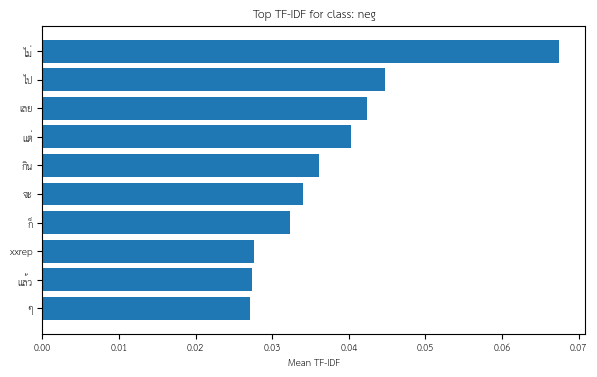

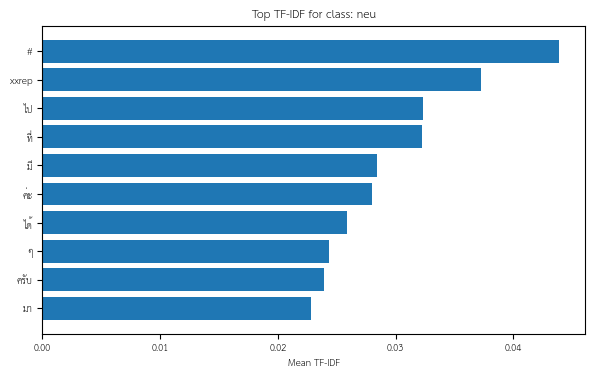

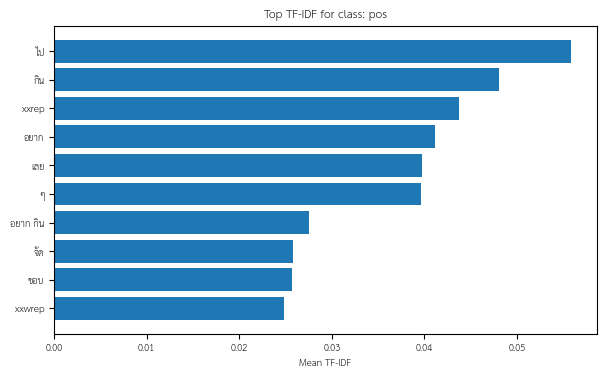

In [13]:
# %matplotlib inline
for df_class in dfs:
    plt.figure(figsize=(7,4))
    plt.barh(df_class['feature'][::-1], df_class['tfidf'][::-1])
    plt.title(f"Top TF-IDF for class: {df_class['class'][0]}")
    plt.xlabel("Mean TF-IDF")
    plt.show()

# GridSearchCV model

In [14]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "C": [0.1, 0.5, 1, 2, 5, 10],
    "penalty": ["l1", "l2"],
    "solver": ["liblinear"]
}
gs = GridSearchCV(LogisticRegression(max_iter=1000, multi_class="ovr"), param_grid, cv=5, scoring='f1_macro')
gs.fit(text_train, y_train)
print("Best Params:", gs.best_params_)
print("Best CV Score:", gs.best_score_)

# ทำนายบน valid
y_pred = gs.predict(text_valid)
from sklearn.metrics import classification_report
print(classification_report(y_valid, y_pred))


Best Params: {'C': 2, 'penalty': 'l1', 'solver': 'liblinear'}
Best CV Score: 0.5371099419437011
              precision    recall  f1-score   support

         neg       0.68      0.51      0.58       154
         neu       0.67      0.86      0.75       338
         pos       0.53      0.25      0.34       108

    accuracy                           0.66       600
   macro avg       0.63      0.54      0.56       600
weighted avg       0.65      0.66      0.63       600



In [15]:
# RandomForest GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

rf = RandomForestClassifier(class_weight="balanced", random_state=42, n_jobs=-1)
gs_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='f1_macro')
gs_rf.fit(text_train, y_train)

print("Best Params RF:", gs_rf.best_params_)
print("Best RF CV Score:", gs_rf.best_score_)

y_pred_rf = gs_rf.predict(text_valid)
print(classification_report(y_valid, y_pred_rf, digits=3))


Best Params RF: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}
Best RF CV Score: 0.5579559923248244
              precision    recall  f1-score   support

         neg      0.565     0.591     0.578       154
         neu      0.707     0.692     0.700       338
         pos      0.380     0.380     0.380       108

    accuracy                          0.610       600
   macro avg      0.551     0.554     0.552       600
weighted avg      0.612     0.610     0.611       600



In [16]:
# SVM (LinearSVC) GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

param_grid_svm = {
    'C': [0.1, 1, 2, 5, 10]
}

svm = LinearSVC(class_weight='balanced', max_iter=3000)
gs_svm = GridSearchCV(svm, param_grid_svm, cv=5, scoring='f1_macro')
gs_svm.fit(text_train, y_train)

print("Best Params SVM:", gs_svm.best_params_)
print("Best SVM CV Score:", gs_svm.best_score_)

y_pred_svm = gs_svm.predict(text_valid)
print(classification_report(y_valid, y_pred_svm, digits=3))

Best Params SVM: {'C': 0.1}
Best SVM CV Score: 0.5660983412608145
              precision    recall  f1-score   support

         neg      0.617     0.597     0.607       154
         neu      0.683     0.757     0.718       338
         pos      0.447     0.315     0.370       108

    accuracy                          0.637       600
   macro avg      0.582     0.557     0.565       600
weighted avg      0.624     0.637     0.627       600



In [17]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# 1. ตั้งค่าพารามิเตอร์
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.05, 0.1, 0.2]
}

# 2. เตรียม model
xgb = XGBClassifier(
    # use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=0,
    n_jobs=-1
)
gs_xgb = GridSearchCV(xgb, param_grid_xgb, cv=5, scoring='f1_macro')

# 3. แปลง label เป็นตัวเลข
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_valid_enc = le.transform(y_valid)

# 4. train grid search
gs_xgb.fit(text_train, y_train_enc)

# 5. ทำนาย + กลับ label กลับเป็นชื่อเดิม
y_pred_xgb = gs_xgb.predict(text_valid)
y_pred_xgb_label = le.inverse_transform(y_pred_xgb)

# 6. รายงานผล
print("Best Params XGB:", gs_xgb.best_params_)
print("Best XGB CV Score:", gs_xgb.best_score_)

print(classification_report(y_valid, y_pred_xgb_label, digits=3))   # <-- แบบ string label!

Best Params XGB: {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 200}
Best XGB CV Score: 0.5304657731327121
              precision    recall  f1-score   support

         neg      0.579     0.526     0.551       154
         neu      0.659     0.766     0.709       338
         pos      0.493     0.306     0.377       108

    accuracy                          0.622       600
   macro avg      0.577     0.533     0.546       600
weighted avg      0.608     0.622     0.609       600



In [18]:
# Assume wc, uwc, text_train, text_valid, y_train, y_valid ถูกสร้างไว้แล้ว
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import numpy as np

# scale wc, uwc
scaler = StandardScaler()
scaler_fit = scaler.fit(df[["wc","uwc"]].astype(float))
num_train = scaler_fit.transform(train_df[["wc","uwc"]].astype(float))
num_valid = scaler_fit.transform(valid_df[["wc","uwc"]].astype(float))

# combine features
X_train = np.concatenate([num_train, text_train.toarray()], axis=1)
X_valid = np.concatenate([num_valid, text_valid.toarray()], axis=1)

# กำหนดพารามิเตอร์ที่ต้องการทดสอบ
param_grid = {
    "C": [0.1, 0.5, 1, 2, 5, 10],
    "penalty": ["l1", "l2"],
    "solver": ["liblinear"]  # ต้องใช้ liblinear ถ้า penalty='l1'
}

gs = GridSearchCV(
    LogisticRegression(dual=False, multi_class="ovr", max_iter=1000),
    param_grid=param_grid,
    cv=5,
    scoring='f1_macro'
)

gs.fit(X_train, y_train)

print("Best LR params:", gs.best_params_)
print("Best LR CV score:", gs.best_score_)

y_pred = gs.predict(X_valid)

model_score = gs.score(X_valid, y_valid)  # accuracy
print("Score (accuracy):", model_score)
print(classification_report(y_valid, y_pred, digits=3))

Best LR params: {'C': 2, 'penalty': 'l1', 'solver': 'liblinear'}
Best LR CV score: 0.5395735093972922
Score (accuracy): 0.5622787881499485
              precision    recall  f1-score   support

         neg      0.686     0.526     0.596       154
         neu      0.671     0.855     0.752       338
         pos      0.529     0.250     0.340       108

    accuracy                          0.662       600
   macro avg      0.629     0.544     0.562       600
weighted avg      0.649     0.662     0.637       600



## Logistic Regression

In [21]:
#word count and unique word counts; actually might not be so useful
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler_fit = scaler.fit(df[["wc","uwc"]].astype(float))
print(scaler_fit.mean_, scaler_fit.var_)
num_train = scaler_fit.transform(train_df[["wc","uwc"]].astype(float))
num_valid = scaler_fit.transform(valid_df[["wc","uwc"]].astype(float))
# num_test = scaler_fit.transform(test_df[["wc","uwc"]].astype(float))
num_train.shape, num_valid.shape

#concatenate text and word count features
X_train = np.concatenate([num_train,text_train.toarray()],axis=1)
X_valid = np.concatenate([num_valid,text_valid.toarray()],axis=1)
# X_test = np.concatenate([num_test,text_test.toarray()],axis=1)
print(X_train.shape, X_valid.shape)

#fit logistic regression models
model = LogisticRegression(C=2., penalty="l1", solver="liblinear", dual=False, multi_class="ovr")
model.fit(X_train,y_train)
model_score = model.score(X_valid,y_valid)

y_pred = model.predict(X_valid)


print("Score(accuracy) :",model_score)

print(classification_report(y_valid, y_pred, digits=3))

[27.311      19.00066667] [1965.16694567  531.19866622]
(2400, 474) (600, 474)
Score(accuracy) : 0.6616666666666666
              precision    recall  f1-score   support

         neg      0.686     0.526     0.596       154
         neu      0.671     0.855     0.752       338
         pos      0.529     0.250     0.340       108

    accuracy                          0.662       600
   macro avg      0.629     0.544     0.562       600
weighted avg      0.649     0.662     0.637       600



### See Results

In [22]:
probs = model.predict_proba(X_valid)
probs_df = pd.DataFrame(probs)
probs_df.columns = model.classes_
probs_df["preds"] = model.predict(X_valid)
probs_df["Sentiment"] = valid_df["Sentiment"]
probs_df["Text"] = valid_df["Text"]
probs_df["processed"] = valid_df.processed
probs_df["wc"] = valid_df.wc
probs_df["uwc"] = valid_df.uwc
probs_df["hit"] = (probs_df.preds==probs_df["Sentiment"])
probs_df.to_csv("probs_df_linear.csv", index=False)

0.6616666666666666


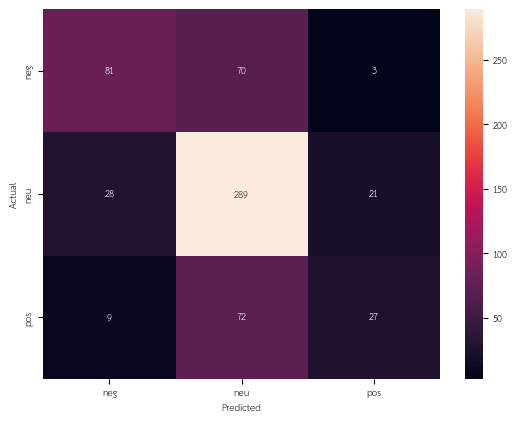

In [23]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(probs_df["Sentiment"],probs_df.preds)
print(model.score(X_valid,y_valid))
sns.heatmap(conf_mat, annot=True, fmt="d",
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# Pre-trained Model

### WangchanBERTa-finetuned-sentiment

In [26]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 1. โหลดข้อมูล
df = pd.read_csv('rawdata_sentiment.csv')
print(df.head())

# ระบุคอลัมน์ข้อความ/label
text_col = 'Text'
label_col = 'Sentiment'

# 2. โหลดโมเดล sentiment
model_name = "poom-sci/WangchanBERTa-finetuned-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# label_names = ["neu", "neg", "pos"]  # ตามลำดับโมเดล
label_names = ["pos", "neu", "neg"]

def sentiment_predict(text):
    # Robust: handle NaN, force string, truncate
    if pd.isna(text) or text is None:
        text = ""
    text = str(text)[:512]    # truncate to max_length 512 chars
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        logits = model(**inputs).logits
    pred = torch.argmax(logits, axis=1).item()
    return label_names[pred]

# เช็คและเตรียมข้อมูลก่อน apply
df[text_col] = df[text_col].fillna("").astype(str)

# 3. ทำนาย sentiment
df['pred_sentiment'] = df[text_col].apply(sentiment_predict)

# 4. วัดผล
y_true = df[label_col].astype(str).str.lower()
y_pred = df['pred_sentiment']

print("\nAccuracy:", accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred, digits=3))
print("Confusion matrix:\n", confusion_matrix(y_true, y_pred, labels=label_names))

# 5. Export ผลลัพธ์ (optional)
# df.to_csv("sentiment_predict_wangchanberta.csv", index=False)

                                                Text Sentiment
0                                      นี้ๆชวนบ่อยสะ       neu
1  (พยาบาลพัฒนาระบบคุณภาพ), โรงพยาบาลกรุงเทพภูเก็...       neu
2  เคยเจอแบบนี้ตอนนั่งแท็กซี่กลับจากคอนเสิร์ตคนเด...       neu
3                                        นิสสันมาแหะ       neu
4                                  อยากกินอ่ะหมู 😣😣😣       pos

Accuracy: 0.808
              precision    recall  f1-score   support

         neg      0.862     0.830     0.846       772
         neu      0.797     0.900     0.846      1688
         pos      0.752     0.489     0.593       540

    accuracy                          0.808      3000
   macro avg      0.804     0.740     0.761      3000
weighted avg      0.806     0.808     0.800      3000

Confusion matrix:
 [[ 264  260   16]
 [  82 1519   87]
 [   5  126  641]]
